<h1><center>Student Monitoring System</center></h1>


In [19]:
# Import libraries
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

### Function to find the distracted student in the dictionary of students present in the class

In [20]:
# Find the distraced student based on the data present in the dictionary
# Variance for all the student coordinate data is created and put in a list. Then mean and variance of this data is
# found, The variances are normalized based on the size of the box. Greater the size of the box neaerer is the 
# student hence higher variance and vice versa. They are normalized on the basis of box size and the distraced
# student is found whose normalized variance is higher than the mean+variance of this data of normalized variances

def find_distracted (students):
        
    var_o_var = [] # To store the data of varinaces
    key = []
    for s in students:
        
        nt = students [s] ['df'].values [33].tolist()
        ntx = nt [0::2]
        mean = np.mean (ntx)
        sigma = np.std (ntx)
        sigmanorm = np.std(ntx)/abs(students [s]['box'][1] - students[s]['box'][0])

        var_o_var.append (sigmanorm)
        key.append (s)
        
    sigma_s = np.std (var_o_var)
    
    mean_s = np.mean (var_o_var)
    
    disturbed = []
    #print ("threshold: ", mean_s + sigma_s)
    for i in range (len (var_o_var)):
        #print (var_o_var [i])
        if var_o_var [i] > mean_s + sigma_s:
            disturbed.append (key [i])
            
    return disturbed
        


In [21]:
#########Function to get disturbed students by weighting landmarks
def find_distractedw (students):
        
    var_o_var = []
    key = []
    for s in students:
        #26,32,7,1,13
        nt1 = students [s] ['df'].values [27].tolist()#mid of eyes
        nt2 = students [s] ['df'].values [33].tolist()#nose
        nt3 = students [s] ['df'].values [8].tolist()#chin
        nt4 = students [s] ['df'].values [14].tolist()#rightmost
        nt5 = students [s] ['df'].values [2].tolist()#leftmost
        nt1 = nt1[0::2]
        nt2 = nt1[0::2]
        nt3 = nt1[0::2]
        nt4 = nt1[0::2]
        nt5 = nt1[0::2]
        
        meant1 = np.mean (nt1)
        sigmant1 = np.std (nt1)
        sigmanormnt1 = sigmant1/abs(students [s]['box'][1] - students[s]['box'][0])
        
        meant2 = np.mean (nt2)
        sigmant2 = np.std (nt2)
        sigmanormnt2 = sigmant2/abs(students [s]['box'][1] - students[s]['box'][0])
        
        meant3 = np.mean (nt3)
        sigmant3 = np.std (nt3)
        sigmanormnt3 = sigmant3/abs(students [s]['box'][1] - students[s]['box'][0])
        
        meant4 = np.mean (nt4)
        sigmant4 = np.std (nt4)
        sigmanormnt4 = sigmant4/abs(students [s]['box'][1] - students[s]['box'][0])
        
        meant5 = np.mean (nt5)
        sigmant5 = np.std (nt5)
        sigmanormnt5 = sigmant5/abs(students [s]['box'][1] - students[s]['box'][0])
        
        w1 = 2.5
        w2 = 3
        w3 = 2.5
        w4 = 1.5
        w5 = 1.5
        
       
        var_o_var.append (w1*sigmanormnt1 + w2*sigmanormnt2 + w3*sigmanormnt3 + w4*sigmanormnt4 + w5*sigmanormnt5)
        key.append (s)
        
    sigma_s = np.std (var_o_var)
    
    mean_s = np.mean (var_o_var)
    
    disturbed = []
    print ("threshold: ", mean_s + sigma_s)
    for i in range (len (var_o_var)):
        print (var_o_var [i])
        if var_o_var [i] > mean_s + sigma_s:
            disturbed.append (key [i])
            
    return disturbed

### Function to find the student the face found in the frame belongs to

In [22]:
# Finding the student the face belongs to detected in the current frame
# The face is said to belong to some student if the new coordinates of the box have high probablity of being a part
# of that student based on the pdf (probablity distribution) formed using the prior data of the coordinates
# The face is then said to be the part of a student for whom the probablity is maximum and above the threshold
# 0.00000001 
# If the probablity does not exceed the threshold the face is said to be a new student and a new student entry is 
# made in the dictionary of students

def find_face (x1,y1,stu):
    
    maxx = 0.0 # variable
    maxy = 0.0 # variable
    sdnt = ''
    flag = 0 # Threshold satisfaction flag
    
    for s in stu:
        temp1 = norm.pdf (x1, np.mean (stu [s] ['x1']), stu [s]['sd']) # Find probablity for x coordinate
        temp2 = norm.pdf (y1 ,np.mean (stu [s] ['y1']), stu [s]['sd']) # Find probablity for y coordinate
        if (temp1 > maxx and temp1 > 0.00000001): # Check threshold for x
            maxx = temp1
            if(temp2 > maxy and temp2 > 0.00000001): # Check threshold for y
                maxy = temp2
                sdnt = s
                flag = 1 # Student found
            
    if (flag == 0): # No student found so new entry in the dictionary created
        stu [len (stu) + 1] = {'x1': [x1],'y1':[y1], 'df':pd.DataFrame (), 'sd': 10}
        return (len (stu), stu)
    
    stu [sdnt] ['x1'].append (x1)
    stu [sdnt] ['y1'].append (y1)
    return (sdnt, stu)

### Main function of the system

In [23]:
# Main function which monitors the student

def student_monitoring (n):
    
    df = pd.DataFrame()
    students = {} # Dictionary which will store the data of all students detected in the video frames
    distracted = [] # Holds the value of current distracted student
    symm = []
    behaviour = []

    cap = cv2.VideoCapture(0) # Start capturing the video
    detector = dlib.get_frontal_face_detector() # DLIB library face detector
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # Landmark detetctor

    for i in range (n): # Run the system for n number of frames as passed by the user
        _, frame = cap.read() # Read one frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Grayscale them

        faces = detector(gray) # Detect the faces in the frame using the DLIB face detector

        for face in faces: # For all the faces found in the frame

            x1 = face.left() # Top left x coordinate of the bounding box
            y1 = face.top() # Top left y coordinate of the bounding box
            x2 = face.right() # Bottom right x coordinate fo the bounding box
            y2 = face.bottom() # Bottom right y coordinate of the bounding box


            f, students = find_face(x1, y1, students) # Find the student the given face belongs to
            

            #print ("student (f): ", f)
            #print ("distracted: ", distracted)
            # If the given student is the distracted student found as per the prior iteration, bound the student 
            # with blue box
            if f in distracted:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
            else:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 3)

            # Find the landmarks on the given face    
            landmarks = predictor(gray, face)
            xc = []
            yc = []
            for n in range(0, 68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                xc.append(x)
                yc.append(y)
                # Mark the landmarks on the face in the frame
                cv2.circle(frame, (x, y), 4, (255, 0, 0), -1)
            
            index = int (len (students [f] ['df'].columns) / 2)
            students [f] ['df'] ['x'+str(index)] = xc
            students [f] ['df'] ['y'+str(index)] = yc
            students [f] ['box'] = list ((x1, x2))
        
        
        cv2.imshow("Frame", frame)
        # Print the number of distinct students detected by the system
        #print (len (students))
        
        # Find the distracted student based on the current data
        behaviour = find_distracted (students)
        symm = symmetry (students)
        w_behaviour = find_distractedw (students)
        distracted = w_behaviour

        key = cv2.waitKey(1)
        if key == 27:
            break

    cap.release ()
    cv2.destroyAllWindows ()
    
    # plot the distribution of nose points
    plot_distributions (students)

### Plot the probablity distribution of students with respect to their x coordinates

In [24]:
def plot_distributions (students):

    for s in students:

        nt = students [s] ['df'].values [33].tolist()
        ntx = nt [0::2]
        ntx.sort()
        mean = np.mean (ntx)
        sigma = np.std (ntx)
        sigmanorm = np.std(ntx)/abs(students [s]['box'][1] - students[s]['box'][0])
        plt.plot (ntx, norm.pdf (ntx, mean, sigma))
        #plt.show () # Uncomment the syntax to get individual plots of each student
        
        # Comment all print statements to just get the plot
        #print (s)
        #print (ntx)
        #print (students [s]['box'][1] - students[s]['box'][0])
        #print (sigma)
        #print (sigmanorm)

    plt.show () # Comment the syntax when plotting individual plots for each student

### Run the system (Parameter value is the number of frames you want to run the system for)

In [25]:
def symmetry (students):
    
    distracted = []
    for s in students:
        
        p0 = students [s] ['df'].values [0].tolist()
        p16 = students [s] ['df'].values [16].tolist()
        p27 = students [s] ['df'].values [27].tolist()
        
        
        lside = abs (p0 [-2] - p27 [-2])
        rside = abs (p16 [-2] - p27 [-2])
        
        if (norm.pdf (lside - rside, 0, 10) < 0.000001):
            distracted.append (s)
            
    return distracted

In [29]:
# Main function which monitors the student

def student_monitoring_video (path):
    
    df = pd.DataFrame()
    students = {} # Dictionary which will store the data of all students detected in the video frames
    distracted = [] # Holds the value of current distracted student
    symm = []
    behaviour = []
    
    
    cap = cv2.VideoCapture (path)

    #cap = cv2.VideoCapture(0) # Start capturing the video
    detector = dlib.get_frontal_face_detector() # DLIB library face detector
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # Landmark detetctor

    ret = True
    while ret: # Run the system for n number of frames as passed by the user
        ret, frame = cap.read() # Read one frame
        if ret == False:
            break
        gray = cv2.cvtColor (frame, cv2.COLOR_BGR2GRAY) # Grayscale them

        faces = detector(gray) # Detect the faces in the frame using the DLIB face detector

        for face in faces: # For all the faces found in the frame

            x1 = face.left() # Top left x coordinate of the bounding box
            y1 = face.top() # Top left y coordinate of the bounding box
            x2 = face.right() # Bottom right x coordinate fo the bounding box
            y2 = face.bottom() # Bottom right y coordinate of the bounding box


            f, students = find_face(x1, y1, students) # Find the student the given face belongs to
            

            #print ("student (f): ", f)
            #print ("distracted: ", distracted)
            # If the given student is the distracted student found as per the prior iteration, bound the student 
            # with blue box
            if f in distracted:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
            else:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 3)

            # Find the landmarks on the given face    
            landmarks = predictor(gray, face)
            xc = []
            yc = []
            for n in range(0, 68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                xc.append(x)
                yc.append(y)
                # Mark the landmarks on the face in the frame
                cv2.circle(frame, (x, y), 4, (255, 0, 0), -1)
            
            index = int (len (students [f] ['df'].columns) / 2)
            students [f] ['df'] ['x'+str(index)] = xc
            students [f] ['df'] ['y'+str(index)] = yc
            students [f] ['box'] = list ((x1, x2))
        
        
        cv2.imshow("Frame", frame)
        # Print the number of distinct students detected by the system
        #print (len (students))
        
        # Find the distracted student based on the current data
        behaviour = find_distracted (students)
        symm = symmetry (students)
        w_behaviour = find_distractedw (students)
        distracted = []
        
        for s in students:
            count = 0
            if s in behaviour:
                count = count + 1
            if s in symm:
                count = count + 1
            if s in w_behaviour:
                count = count + 1
                
            if count > 1:
                distracted.append (s)

        key = cv2.waitKey(1)
        if key == 27:
            break

    cap.release ()
    cv2.destroyAllWindows ()
    
    print (len (students))
    # plot the distribution of nose points
    plot_distributions (students)

threshold:  0.0
0.0
0.0
0.0
0.0
0.0
0.0
threshold:  0.0
0.0
0.0
0.0
0.0
0.0
0.0
threshold:  0.0
0.0
0.0
0.0
0.0
0.0
0.0
threshold:  0.007409091635277978
0.0
0.0
0.0
0.015035163260146502
0.0
0.0
0.0
threshold:  0.03580682117924404
0.0
0.0
0.0
0.07266226802937997
0.0
0.0
0.0
threshold:  0.03597967297902059
0.0
0.0
0.0
0.0730130337044968
0.0
0.0
0.0
threshold:  0.037555492437993304
0.0
0.0
0.0
0.0762108215036595
0.0
0.0
0.0
threshold:  0.03864400047086753
0.011483295620940064
0.0
0.0
0.07583760132902526
0.0
0.0
0.0
threshold:  0.07060192766371962
0.061657628806998224
0.0
0.0581343639071998
0.07420338700984697
0.0
0.0
0.06954081148227458
threshold:  0.0714250072954576
0.06313394338526333
0.0
0.057638888888888885
0.07374689564542171
0.0
0.0
0.07202013512085206
threshold:  0.09003306874417454
0.07235489804202577
0.0
0.05397864494923317
0.07111587298974413
0.0
0.0
0.1231792510724574
threshold:  0.09134990229780224
0.07277020900281744
0.0
0.05359342314049181
0.07068708585353219
0.0
0.0
0.12667

threshold:  0.28063534074424773
0.08127901199987851
0.0
0.07533142997086768
0.21432363606639407
0.0
0.5011466117209182
0.09126338788181212
0.034722222222222224
threshold:  0.28157218768578296
0.08113501853700275
0.0
0.07656561577387794
0.21541489119994073
0.0
0.5026576112167888
0.09110172182618366
0.034722222222222224
threshold:  0.24932984251402046
0.07999797847054932
0.0
0.08528407295455316
0.21551873570660546
0.0
0.5028129330651498
0.08977335981204448
0.034722222222222224
0.0
0.0
threshold:  0.24988945879392432
0.07986073434975176
0.0
0.08802302494861446
0.21625293250967592
0.0
0.5033741922775262
0.08961938925149084
0.034722222222222224
0.0
0.0
threshold:  0.2532815025350708
0.07877567001437856
0.0
0.12309478726669612
0.2163159303252758
0.0
0.5034161079840193
0.08835390567278542
0.034722222222222224
0.0
0.0
threshold:  0.25208331838870407
0.07864466395745137
0.0
0.12667309868872756
0.21675719912820934
0.0
0.49890318409722195
0.08820704071974989
0.034722222222222224
0.0
0.0
threshold

threshold:  0.2545405794400478
0.08194744278343791
0.15476853741322763
0.4316954695195807
0.22771098511149312
0.0
0.4983238579449917
0.08492037148664977
0.034722222222222224
0.0
0.0
0.2170283950651351
0.0
0.0
0.0
0.0
0.0
0.0
17


/home/ankit/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/ankit/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/ankit/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/ankit/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/ankit/.local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/ankit/.local/lib/python3.7/site-packages/scipy/stats/_distn_infr

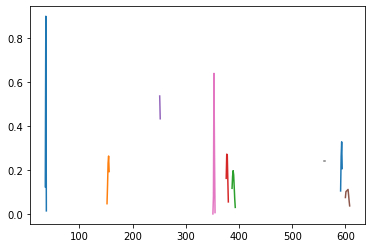

In [30]:
student_monitoring_video ("/home/ankit/ankit/projects/Smart_Monitoring_System/test-cases/test (1).mp4")